In [2]:
import numpy as np
import pickle

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from sklearn.metrics import confusion_matrix
import keras
from keras.layers import LSTM
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dropout

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def print_confusion_result_lstm(x_train, x_test, y_train, y_test, model):
  # get train & test predictions
  train_pred = model.predict_classes(x_train)
  test_pred = model.predict_classes(x_test)
    
  # get train & test true labels
  train_label = y_train
  test_label =  y_test
    
  # confusion matrix
  train_result_cm = confusion_matrix(train_label, train_pred, labels=range(10))
  test_result_cm = confusion_matrix(test_label, test_pred, labels=range(10))
  plot_confusion_matrix(train_result_cm, classes=range(10),
                      title='Train Confusion matrix')
  plot_confusion_matrix(test_result_cm, classes=range(10),
                      title='Test Confusion matrix')
  # print(train_result_cm, '\n'*2, test_result_cm)

def print_confusion_result_cnn(x_train, x_test, data, model):
  # get train & test predictions
  train_pred = model.predict_classes(x_train)
  test_pred = model.predict_classes(x_test)
    
  # get train & test true labels
  train_label = data['train_label'][:, 0]
  test_label = data['test_label'][:, 0]
    
  # confusion matrix
  train_result_cm = confusion_matrix(train_label, train_pred, labels=range(10))
  test_result_cm = confusion_matrix(test_label, test_pred, labels=range(10))
  plot_confusion_matrix(train_result_cm, classes=range(10),
                      title='Train Confusion matrix')
  plot_confusion_matrix(test_result_cm, classes=range(10),
                      title='Test Confusion matrix')
  # print(train_result_cm, '\n'*2, test_result_cm)

def data_preprocess_modeling(modelname,x_train, y_train, x_test, y_test):
  
  n_classes = 10
  # shaping data to fit lstm/cnn requirments
  if modelname == 'lstm':
    _,n_step,n_input,channel = x_train.shape
    n_input = n_input*channel
    x_train = x_train.reshape(-1, n_step, n_input)
    
    # one hot encoding for category number 0~9
    x_test = x_test.reshape(-1, n_step, n_input)
    y_train = keras.utils.to_categorical(y_train, n_classes)
    y_test = keras.utils.to_categorical(y_test, n_classes)

    # set color range to 0~1
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
  elif modelname == 'cnn':
    _,width,height,channel = x_train.shape
  
    # x_train = x_train.reshape(-1, width, height, channel)
    # x_test = x_test.reshape(-1, width, height, channel)

  # set color range to 0~1
  # x_train = x_train.astype('float32')
  # x_test = x_test.astype('float32')
  # x_train /= 255
  # x_test /= 255

 
  


  model = Sequential()
  if modelname == 'lstm':
    n_classes = 10
    # model.add(LSTM(1024, batch_input_shape=(None, n_step, n_input),return_sequences=False))
    model.add(LSTM(1024, batch_input_shape=(None, n_step, n_input),return_sequences=True))
    model.add(LSTM(512))
    # model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
  elif modelname == 'cnn':
    # model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(width, height, channel)))
    # model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(10, 10, 4)))
    model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(9, activation='softmax'))


    # n_classes = 9
    
    # model.add(MaxPool2D(strides=2))
    # model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    # model.add(MaxPool2D(strides=2))
    # model.add(Flatten())
    # model.add(Dense(128, activation='relu'))
    # # model.add(Dropout(0.2))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dense(n_classes, activation='softmax'))
  model.summary()
  return model, x_train, y_train, x_test, y_test


def model_training(model, x_train, y_train, x_test, y_test, epochs, learning_rate=0.001, batch_size=64):
  adam = Adam(lr=learning_rate)
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs,
            verbose=1, validation_data=(x_test, y_test))

def LSTM_run(x_train,y_train,x_test,y_test,epochs):
  model, x_train, y_train_ohe, x_test, y_test_ohe = data_preprocess_modeling('lstm',x_train,y_train,x_test,y_test)
  model_training(model, x_train, y_train_ohe, x_test, y_test_ohe,epochs)
  scores = model.evaluate(x_test, y_test_ohe, verbose=0)
  print('LSTM test accuracy:', scores[1])
  print_confusion_result_lstm(x_train, x_test, y_train, y_test, model)


def CNN_run(x_train,y_train,x_test,y_test,epochs):
  model, x_train, y_train, x_test, y_test = data_preprocess_modeling('cnn',x_train,y_train,x_test,y_test)
  model_training(model, x_train, y_train, x_test, y_test,epochs)
  scores = model.evaluate(x_test, y_test, verbose=0)
  print('CNN test accuracy:', scores[1])
  print_confusion_result_cnn(x_train, x_test, data, model)


def load_pkl(pkl_name):
    # load data from data folder
    with open(pkl_name, 'rb') as f:
        data = pickle.load(f)
    return data


Found GPU at: /device:GPU:0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 1024)          4362240   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               3147776   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 7,584,586
Trainable params: 7,584,586
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


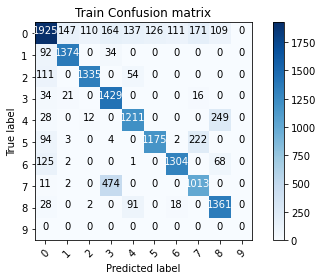

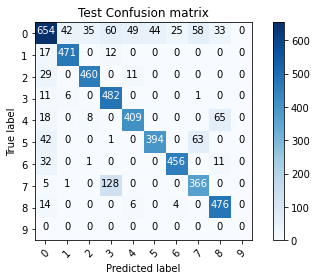

In [3]:
data = load_pkl('label8_eurusd_10bar_1500_500_val200_gaf_culr.pkl')

x_train, y_train, x_test, y_test = data['train_gaf'], data['train_label'][:, 0], data['test_gaf'], data['test_label'][:, 0]
LSTM_run(x_train,y_train,x_test,y_test,epochs=10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 32)        3232      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 48)          38448     
_________________________________________________________________
flatten (Flatten)            (None, 1728)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               442624    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 84)                21588     
_________________________________________________________________
dense_5 (Dense)              (None, 9)                

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


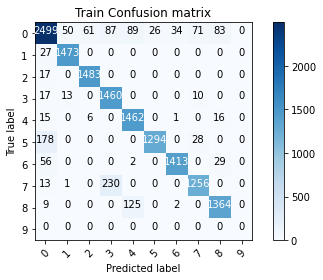

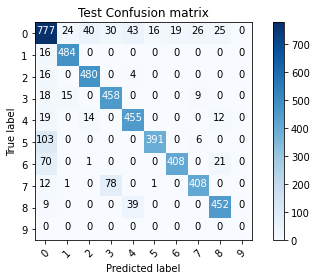

In [4]:
x_train, y_train, x_test, y_test = data['train_gaf'], data['train_label_arr'], data['test_gaf'], data['test_label_arr']
CNN_run(x_train,y_train,x_test,y_test,10)

In [ ]:
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb